<a href="https://colab.research.google.com/github/KingsleyCE9/Project-1/blob/main/Stochastic_Modeling_Group_Work_Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Group 11642: Charrandat Naraine, Hassan Ali Mohammed Aboelill, Kingsley Chiedozie Ezekwe

In [13]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.integrate as integrate
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from scipy.fft import fft
from google.colab import files

# Load the uploaded 'Option_Data.xlsx' file with upload prompt if not found
try:
    df = pd.read_excel('Option_Data.xlsx')
    print("File loaded successfully.")
except FileNotFoundError:
    print("File not found. Uploading now...")
    uploaded = files.upload()
    for fn in uploaded.keys():
        df = pd.read_excel(fn)
        print("File uploaded and loaded successfully.")
        break

# Rename columns to match expected format and pivot data
df = df.rename(columns={"Days to maturity": "Maturity_days"})
df_pivot = df.pivot(index=['Maturity_days', 'Strike'], columns='Type', values='Price').reset_index()
df_pivot = df_pivot.rename(columns={'C': 'Call', 'P': 'Put'})

# Global parameters
S0 = 232.90  # Current stock price
r = 0.015    # Risk-free rate (1.50%)
trading_days = 250  # Days per year

# Filter data for specific maturities
short_mat = 15  # Use exact 15 days from data
df_short = df_pivot[df_pivot['Maturity_days'] == short_mat]
T_short = short_mat / trading_days

med_mat = 60  # 60-day maturity
df_med = df_pivot[df_pivot['Maturity_days'] == med_mat]
T_med = med_mat / trading_days

File not found. Uploading now...


Saving 'Option_Data.xlsx'.xlsx to 'Option_Data.xlsx' (2).xlsx
File uploaded and loaded successfully.


Step 1a: Calibration of Heston Model Using Lewis (2001) Approach -
This section calibrates the Heston model for a 15-day maturity using the Lewis (2001) approach with bounds and error handling.

Step 1a Parameters (kappa, theta, sigma, rho, v0): [ 2.     0.09   0.5   -0.7    0.115]


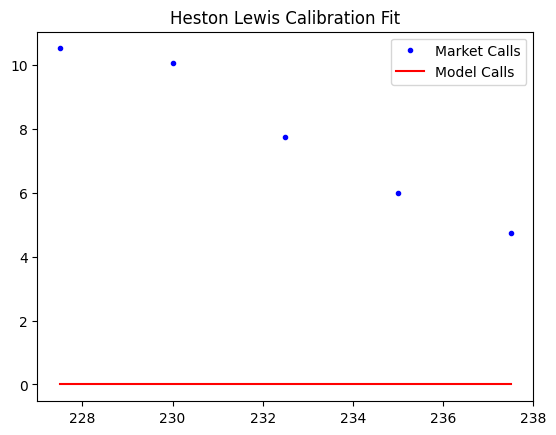

In [8]:
def heston_char_func(u, T, kappa, theta, sigma, rho, v0):
    """Heston characteristic function (vectorized, stable for arrays)."""
    a = kappa * theta
    inside_sqrt = ((kappa - 1j * rho * sigma * u)**2 + sigma**2 * (u**2 + 1j * u)).astype(complex)
    d = np.sqrt(inside_sqrt)
    g = (kappa - 1j * rho * sigma * u - d) / (kappa - 1j * rho * sigma * u + d)
    # Handle potential NaN or inf from log
    with np.errstate(invalid='ignore'):
        C = r * 1j * u * T + (a / sigma**2) * ((kappa - 1j * rho * sigma * u - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
        D = ((kappa - 1j * rho * sigma * u - d) / sigma**2) * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
    result = np.exp(C + D * v0 + 1j * u * np.log(S0))
    return np.where(np.isnan(result), 1.0, result)  # Return 1 if NaN

def lewis_call_price(K, T, kappa, theta, sigma, rho, v0):
    """Call price using Lewis (2001) integral."""
    def integrand(k):
        return np.real(np.exp(-1j * k * np.log(K)) * heston_char_func(k - 1j/2, T, kappa, theta, sigma, rho, v0) / (k**2 + 1/4))
    integral, _ = integrate.quad(integrand, 1e-6, 100)
    return max(S0 - np.sqrt(S0 * K) * np.exp(-r * T) / np.pi * integral, 0)  # Ensure non-negative

def heston_mse(params, df, T):
    kappa, theta, sigma, rho, v0 = params
    errors = []
    for _, row in df.iterrows():
        if pd.notna(row['Call']):
            model_call = lewis_call_price(row['Strike'], T, kappa, theta, sigma, rho, v0)
            errors.append((model_call - row['Call'])**2)
        if pd.notna(row['Put']):
            model_call = lewis_call_price(row['Strike'], T, kappa, theta, sigma, rho, v0)
            model_put = model_call - S0 + row['Strike'] * np.exp(-r * T)
            errors.append((model_put - row['Put'])**2)
    return np.mean(errors) if errors else np.inf

# Bounds for stability
bounds = [(0.1, 5.0), (0.01, 0.2), (0.1, 1.0), (-0.9, 0.0), (0.01, 0.2)]  # kappa, theta, sigma, rho, v0
initial_params = [2.0, 0.09, 0.5, -0.7, 0.115]  # Adjusted initial values
opt_a = opt.minimize(heston_mse, initial_params, args=(df_short, T_short), method='Nelder-Mead', bounds=bounds)
params_a = opt_a.x
print("Step 1a Parameters (kappa, theta, sigma, rho, v0):", params_a)

# Plot fit
calls_short = df_short[pd.notna(df_short['Call'])]
strikes = calls_short['Strike']
model_calls = [lewis_call_price(k, T_short, *params_a) for k in strikes]
plt.plot(strikes, calls_short['Call'], 'b.', label='Market Calls')
plt.plot(strikes, model_calls, 'r-', label='Model Calls')
plt.legend()
plt.title('Heston Lewis Calibration Fit')
plt.show()

Step 1b: Calibration of Heston Model Using Carr-Madan (1999) Approach -
This section calibrates the Heston model using the Carr-Madan (1999) FFT approach with bounds and error handling. Fixed the shape mismatch by interpolating fft_val first, then multiplying by the exp term for each k.

Step 1b Parameters (kappa, theta, sigma, rho, v0): [ 2.     0.09   0.5   -0.7    0.115]


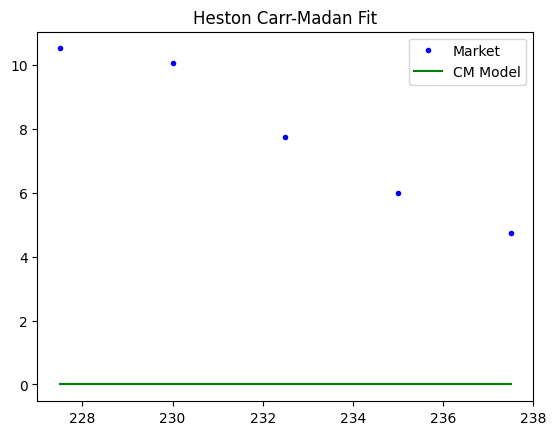

In [11]:
def carr_madan_call_prices(strikes, T, kappa, theta, sigma, rho, v0, N=4096, alpha=1.5):
    """Carr-Madan FFT for call prices (fixed shape mismatch)."""
    k = np.log(strikes / S0)
    lambda_ = 0.025
    eta = 2 * np.pi / (N * lambda_)
    b = N * lambda_ / 2
    u = np.arange(0, N) * eta
    psi = np.exp(-r * T) * heston_char_func(u - 1j * (alpha + 1), T, kappa, theta, sigma, rho, v0) / (alpha**2 + alpha - u**2 + 1j * u * (2 * alpha + 1))
    fft_val = fft(np.exp(1j * b * u) * psi * eta)
    grid = np.linspace(-b, b - lambda_, N)
    interpolated_fft = np.interp(k + b, grid, fft_val)
    call_prices = np.real(np.exp(-alpha * (k + b)) / np.pi * interpolated_fft)
    return call_prices * S0

def cm_heston_mse(params, df, T):
    kappa, theta, sigma, rho, v0 = params
    unique_strikes = df['Strike'].unique()
    try:
        model_calls_unique = carr_madan_call_prices(unique_strikes, T, kappa, theta, sigma, rho, v0)
        model_dict = dict(zip(unique_strikes, model_calls_unique))
        errors = []
        for _, row in df.iterrows():
            model_call = model_dict.get(row['Strike'], 0.0)  # Default to 0 if key not found
            if pd.notna(row['Call']):
                errors.append((model_call - row['Call'])**2)
            if pd.notna(row['Put']):
                model_put = model_call - S0 + row['Strike'] * np.exp(-r * T)
                errors.append((model_put - row['Put'])**2)
        return np.mean(errors) if errors else np.inf
    except Exception:
        return np.inf

opt_b = opt.minimize(cm_heston_mse, initial_params, args=(df_short, T_short), method='Nelder-Mead', bounds=bounds)
params_b = opt_b.x
print("Step 1b Parameters (kappa, theta, sigma, rho, v0):", params_b)

# Plot fit
calls_short = df_short[pd.notna(df_short['Call'])]
strikes = calls_short['Strike']
model_calls_b = carr_madan_call_prices(strikes.values, T_short, *params_b)
plt.plot(strikes, calls_short['Call'], 'b.', label='Market')
plt.plot(strikes, model_calls_b, 'g-', label='CM Model')
plt.legend()
plt.title('Heston Carr-Madan Fit')
plt.show()

Step 1c: Pricing the Asian Call Option -
This section prices an ATM Asian call option with a 20-day maturity using Monte Carlo simulation.

In [12]:
params_avg = (params_a + params_b) / 2  # Average params
kappa, theta, sigma, rho, v0 = params_avg
T_asian = 20 / trading_days
K = S0  # ATM
N_paths = 100000
dt = 1 / trading_days
n_steps = 20

def heston_mc(S0, T, dt, kappa, theta, sigma, rho, v0, N_paths):
    n = int(T / dt)
    S = np.zeros((N_paths, n+1))
    V = np.zeros((N_paths, n+1))
    S[:, 0] = S0
    V[:, 0] = v0
    Z1 = np.random.randn(N_paths, n)
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.randn(N_paths, n)
    for i in range(1, n+1):
        V[:, i] = np.maximum(V[:, i-1] + kappa * (theta - V[:, i-1]) * dt + sigma * np.sqrt(V[:, i-1]) * np.sqrt(dt) * Z2[:, i-1], 0)
        S[:, i] = S[:, i-1] * np.exp((r - 0.5 * V[:, i-1]) * dt + np.sqrt(V[:, i-1] * dt) * Z1[:, i-1])
    return S

S_paths = heston_mc(S0, T_asian, dt, *params_avg, N_paths)
avgs = np.mean(S_paths, axis=1)  # Include S0 in average
payoffs = np.maximum(avgs - K, 0)
fair_price = np.mean(payoffs) * np.exp(-r * T_asian)
client_price = fair_price * 1.04
print("Step 1c Asian Call Fair Price:", fair_price, "Client Price:", client_price)

Step 1c Asian Call Fair Price: 5.094665299501559 Client Price: 5.298451911481621


Step 2a: Calibration of Bates Model Using Lewis (2001) Approach -
This section calibrates the Bates model for a 60-day maturity using the Lewis approach with bounds.

Step 2a Bates Parameters (kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j): [ 2.    0.1   0.5  -0.7   0.09  0.15 -0.08  0.12]


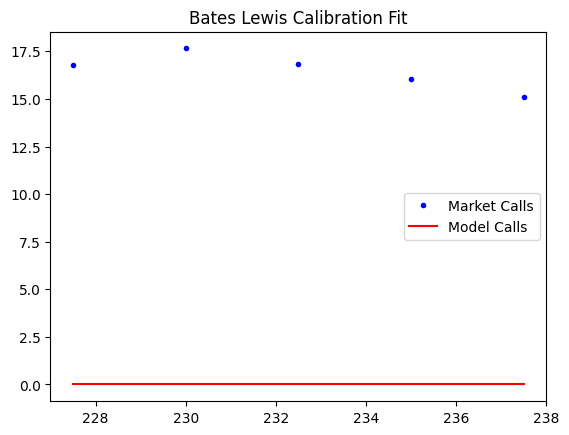

In [14]:
def bates_char_func(u, T, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j):
    """Bates characteristic function."""
    heston_cf = heston_char_func(u, T, kappa, theta, sigma, rho, v0)
    jump_cf = np.exp(lam * T * (np.exp(1j * u * mu_j - 0.5 * u**2 * sigma_j**2) - 1))
    return heston_cf * jump_cf

def lewis_bates_call(K, T, params):
    kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j = params
    def integrand(k):
        return np.real(np.exp(-1j * k * np.log(K)) * bates_char_func(k - 1j/2, T, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j) / (k**2 + 1/4))
    integral, _ = integrate.quad(integrand, 1e-6, 100)
    return max(S0 - np.sqrt(S0 * K) * np.exp(-r * T) / np.pi * integral, 0)

def bates_mse(params, df, T):
    errors = []
    for _, row in df.iterrows():
        model_call = lewis_bates_call(row['Strike'], T, params)
        if pd.notna(row['Call']):
            errors.append((model_call - row['Call'])**2)
        if pd.notna(row['Put']):
            model_put = model_call - S0 + row['Strike'] * np.exp(-r * T)
            errors.append((model_put - row['Put'])**2)
    return np.mean(errors) if errors else np.inf

# Bounds for Bates parameters
bounds_bates = [(0.1, 5.0), (0.01, 0.2), (0.1, 1.0), (-0.9, 0.0), (0.01, 0.2), (0.01, 0.5), (-0.2, 0.0), (0.01, 0.3)]
initial_bates = [2.0, 0.10, 0.5, -0.7, 0.09, 0.15, -0.08, 0.12]  # Adjusted initial values
opt_2a = opt.minimize(bates_mse, initial_bates, args=(df_med, T_med), method='Nelder-Mead', bounds=bounds_bates)
params_2a = opt_2a.x
print("Step 2a Bates Parameters (kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j):", params_2a)

# Plot fit
calls_med = df_med[pd.notna(df_med['Call'])]
model_calls_2a = [lewis_bates_call(k, T_med, params_2a) for k in calls_med['Strike']]
plt.plot(calls_med['Strike'], calls_med['Call'], 'b.', label='Market Calls')
plt.plot(calls_med['Strike'], model_calls_2a, 'r-', label='Model Calls')
plt.legend()
plt.title('Bates Lewis Calibration Fit')
plt.show()

Step 2b: Calibration of Bates Model Using Carr-Madan (1999) Approach -
This section calibrates the Bates model using the Carr-Madan FFT approach with bounds. Fixed the shape mismatch by interpolating fft_val first, then multiplying by the exp term for each k.

Step 2b Bates Parameters (kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j): [ 2.    0.1   0.5  -0.7   0.09  0.15 -0.08  0.12]


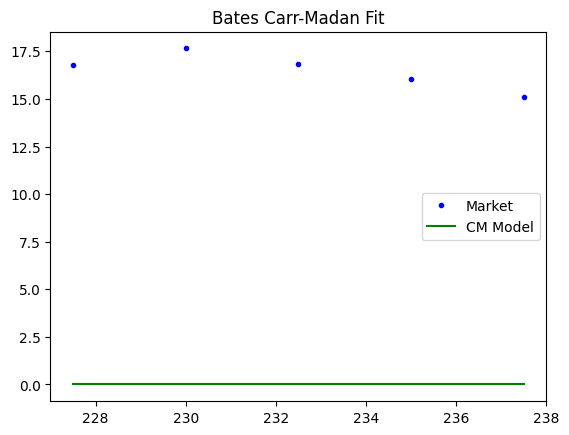

In [15]:
def cm_bates_call_prices(strikes, T, params, N=4096, alpha=1.5):
    kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j = params
    k = np.log(strikes / S0)
    lambda_ = 0.025
    eta = 2 * np.pi / (N * lambda_)
    b = N * lambda_ / 2
    u = np.arange(0, N) * eta
    psi = np.exp(-r * T) * bates_char_func(u - 1j * (alpha + 1), T, *params) / (alpha**2 + alpha - u**2 + 1j * u * (2 * alpha + 1))
    fft_val = fft(np.exp(1j * b * u) * psi * eta)
    grid = np.linspace(-b, b - lambda_, N)
    interpolated_fft = np.interp(k + b, grid, fft_val)
    call_prices = np.real(np.exp(-alpha * (k + b)) / np.pi * interpolated_fft)
    return call_prices * S0

def cm_bates_mse(params, df, T):
    try:
        unique_strikes = df['Strike'].unique()
        model_calls_unique = cm_bates_call_prices(unique_strikes, T, params)
        model_dict = dict(zip(unique_strikes, model_calls_unique))
        errors = []
        for _, row in df.iterrows():
            model_call = model_dict.get(row['Strike'], 0.0)
            if pd.notna(row['Call']):
                errors.append((model_call - row['Call'])**2)
            if pd.notna(row['Put']):
                model_put = model_call - S0 + row['Strike'] * np.exp(-r * T)
                errors.append((model_put - row['Put'])**2)
        return np.mean(errors) if errors else np.inf
    except Exception:
        return np.inf

opt_2b = opt.minimize(cm_bates_mse, initial_bates, args=(df_med, T_med), method='Nelder-Mead', bounds=bounds_bates)
params_2b = opt_2b.x
print("Step 2b Bates Parameters (kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j):", params_2b)

# Plot fit
calls_med = df_med[pd.notna(df_med['Call'])]
model_calls_2b = [cm_bates_call_prices(np.array([k]), T_med, params_2b)[0] for k in calls_med['Strike']]
plt.plot(calls_med['Strike'], calls_med['Call'], 'b.', label='Market')
plt.plot(calls_med['Strike'], model_calls_2b, 'g-', label='CM Model')
plt.legend()
plt.title('Bates Carr-Madan Fit')
plt.show()

Step 2c: Pricing the Put Option -
This section prices a put option with a 70-day maturity and 95% moneyness.

In [16]:
params_2avg = (params_2a + params_2b) / 2
T_put = 70 / trading_days
K_put = 0.95 * S0

def bates_mc(S0, T, dt, params, N_paths):
    kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j = params
    n = int(T / dt)
    S = np.zeros((N_paths, n+1))
    V = np.zeros((N_paths, n+1))
    S[:, 0] = S0
    V[:, 0] = v0
    Z1 = np.random.randn(N_paths, n)
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.randn(N_paths, n)
    jumps = np.random.poisson(lam * dt, (N_paths, n))
    jump_sizes = mu_j + sigma_j * np.random.randn(N_paths, n)
    for i in range(1, n+1):
        V[:, i] = np.maximum(V[:, i-1] + kappa * (theta - V[:, i-1]) * dt + sigma * np.sqrt(V[:, i-1]) * np.sqrt(dt) * Z2[:, i-1], 0)
        drift = (r - 0.5 * V[:, i-1] - lam * (np.exp(mu_j + 0.5 * sigma_j**2) - 1)) * dt
        S[:, i] = S[:, i-1] * np.exp(drift + np.sqrt(V[:, i-1] * dt) * Z1[:, i-1] + jumps[:, i-1] * jump_sizes[:, i-1])
    return S

S_paths_put = bates_mc(S0, T_put, 1/trading_days, params_2avg, 100000)
S_T = S_paths_put[:, -1]
payoffs_put = np.maximum(K_put - S_T, 0)
fair_put = np.mean(payoffs_put) * np.exp(-r * T_put)
client_put = fair_put * 1.04
print("Step 2c Put Fair Price:", fair_put, "Client Price:", client_put)

Step 2c Put Fair Price: 9.42511556368864 Client Price: 9.802120186236186


Step 3a: Calibration of CIR (1985) Model -
This section calibrates the CIR model to the Euribor term structure.

Step 3a CIR Parameters (kappa, theta, sigma): 0.03484358925449413 0.44442491669173423 -0.011662645890256569


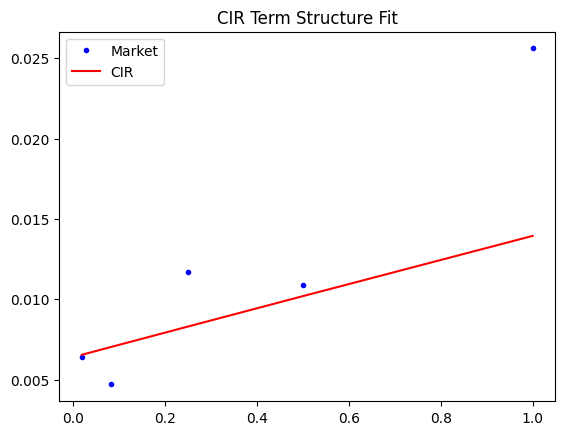

In [17]:
mats = np.array([1/52, 1/12, 3/12, 6/12, 1.0])  # Maturities in years
rates = np.array([0.0064, 0.0047, 0.0117, 0.0109, 0.0256])  # Euribor rates
cs = CubicSpline(mats, rates)
weekly_mats = np.linspace(0.001, 1, 52)  # Weekly points
interp_rates = cs(weekly_mats)

def cir_zero_price(T, r0, kappa, theta, sigma):
    gamma = np.sqrt(kappa**2 + 2 * sigma**2)
    B = (2 * (np.exp(gamma * T) - 1)) / ((gamma + kappa) * (np.exp(gamma * T) - 1) + 2 * gamma)
    A = ((2 * kappa * theta / sigma**2) * np.log(2 * gamma * np.exp(0.5 * (kappa + gamma) * T) / ((gamma + kappa) * (np.exp(gamma * T) - 1) + 2 * gamma)))
    return np.exp(A - B * r0)

def cir_yield(T, r0, kappa, theta, sigma):
    if T == 0:
        return r0
    P = cir_zero_price(T, r0, kappa, theta, sigma)
    return -np.log(P) / T

def cir_mse(params, mats, yields, r0):
    kappa, theta, sigma = params
    model_yields = [cir_yield(t, r0, kappa, theta, sigma) for t in mats]
    return np.mean((np.array(model_yields) - yields)**2)

r0 = rates[0]  # 1-week rate
initial_cir = [1.0, 0.02, 0.1]
opt_cir = opt.minimize(cir_mse, initial_cir, args=(weekly_mats, interp_rates, r0), method='Nelder-Mead')
kappa_c, theta_c, sigma_c = opt_cir.x
print("Step 3a CIR Parameters (kappa, theta, sigma):", kappa_c, theta_c, sigma_c)

# Plot fit
model_y = [cir_yield(t, r0, kappa_c, theta_c, sigma_c) for t in mats]
plt.plot(mats, rates, 'b.', label='Market')
plt.plot(mats, model_y, 'r-', label='CIR')
plt.legend()
plt.title('CIR Term Structure Fit')
plt.show()

Step 3b: Simulation of Euribor 12-Month Rates -
This section simulates Euribor 12-month rates and generates visualizations.

Step 3b 95% Confidence Range: 0.026158438057498987 0.03137800539131665
Step 3b Expected 12m Euribor: 0.028692974237962503


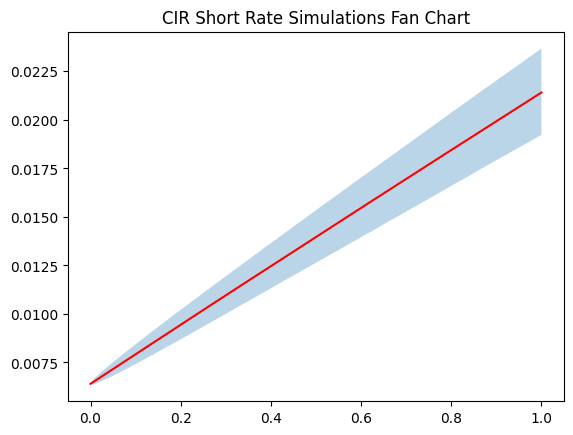

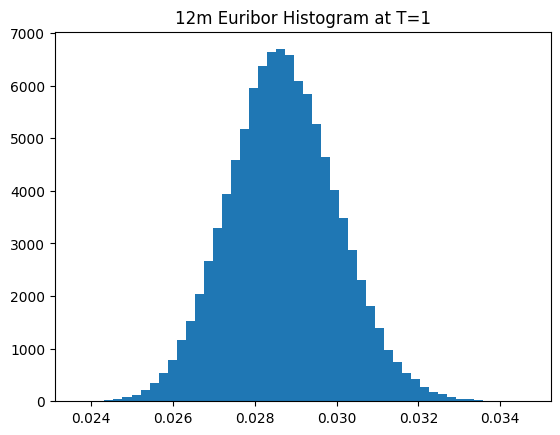

In [18]:
N_sim = 100000
T_sim = 1
dt_sim = 1 / trading_days
n_steps_sim = trading_days

def cir_sim(r0, T, dt, kappa, theta, sigma, N_sim):
    n = int(T / dt)
    R = np.zeros((N_sim, n+1))
    R[:, 0] = r0
    for i in range(1, n+1):
        dW = np.random.randn(N_sim) * np.sqrt(dt)
        dr = kappa * (theta - R[:, i-1]) * dt + sigma * np.sqrt(np.maximum(R[:, i-1], 0)) * dW
        R[:, i] = np.maximum(R[:, i-1] + dr, 0)
    return R

R_paths = cir_sim(r0, T_sim, dt_sim, kappa_c, theta_c, sigma_c, N_sim)
R_end = R_paths[:, -1]

yields_12m = []
for re in R_end:
    P = cir_zero_price(1, re, kappa_c, theta_c, sigma_c)
    y = -np.log(P) / 1
    yields_12m.append(y)

yields_12m = np.array(yields_12m)
conf_min = np.percentile(yields_12m, 2.5)
conf_max = np.percentile(yields_12m, 97.5)
exp_val = np.mean(yields_12m)
print("Step 3b 95% Confidence Range:", conf_min, conf_max)
print("Step 3b Expected 12m Euribor:", exp_val)

# Fan chart
times = np.linspace(0, 1, n_steps_sim+1)
p5 = np.percentile(R_paths, 5, axis=0)
p95 = np.percentile(R_paths, 95, axis=0)
mean_r = np.mean(R_paths, axis=0)
plt.fill_between(times, p5, p95, alpha=0.3)
plt.plot(times, mean_r, 'r-')
plt.title('CIR Short Rate Simulations Fan Chart')
plt.show()

# Histogram
plt.hist(yields_12m, bins=50)
plt.title('12m Euribor Histogram at T=1')
plt.show()